<a href="https://colab.research.google.com/github/MarlenGabrich/GTF/blob/charact/Caract_fp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#    CARACTERIZACIÓN ⚒



1.   Funciones de distribución
2.   Correlación de propiedades
3.   Lumping


In [199]:
# Módulos:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from math import log

In [200]:
# Lectura de archivo
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/main/com-fede" > com.csv
df = pd.read_csv('com.csv')

#Acomodo el índice e imprimo
df = df.reset_index(drop=False).rename(columns={'index': 'ID'})
df = df.set_index("component")
df

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   667  100   667    0     0   8443      0 --:--:-- --:--:-- --:--:--  8551


,ID,molar_percentage,molar_mass,density
component,,,,
N2,0,0.49,—,—
CO2,1,0.31,—,—
C1,2,44.01,—,—
C2,3,3.84,—,—
C3,4,1.12,—,—
iC4,5,0.61,—,—
nC4,6,0.72,—,—
iC5,7,0.69,—,—
nC5,8,0.35,—,—


### SCN
Hago una primera agrupación de limpieza para trabajar con SCN. 


---


Forzar balance?

In [201]:
# Saco la división i-C y n-C
letdel = "ni(\d+)"
for i in range (len(letdel)-5):
  df.index = df.index.str.replace(letdel[i],r"",regex=True)

#Agrupo y ordeno
df_ID = df.groupby([df.index])['ID'].agg('mean')
df_mbc = df.groupby(['component','molar_mass','density'])['molar_percentage'].agg('sum').reset_index().set_index('component').assign(ID=df_ID)
df_mbc = df_mbc.sort_values(by='ID', ascending=True)
df_mbc

,molar_mass,density,molar_percentage,ID
component,,,,
N2,—,—,0.49,0.0
CO2,—,—,0.31,1.0
C1,—,—,44.01,2.0
C2,—,—,3.84,3.0
C3,—,—,1.12,4.0
C4,—,—,1.33,5.5
C5,—,—,1.04,7.5
C6,—,—,1.04,9.0
C7,96,0.738,2.87,10.0


Text(17, 8, '100.02')

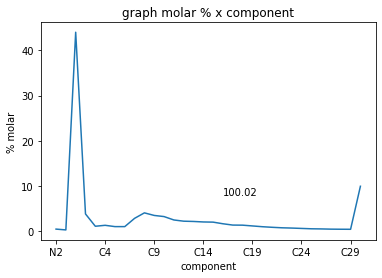

In [202]:
df_mbc['molar_percentage'][:].plot()
plt.ylabel('% molar')
plt.title('graph molar % x component')
suma = df_mbc['molar_percentage'].sum()
plt.text(17,8,round(suma,2))

# 1. Función de distribución

In [203]:
# defino:

z_plus_max = df_mbc["molar_percentage"].values[-1]
m_plus_max = float(df_mbc["molar_mass"].values[-1])
c_max = 80 #Pedersen
c_plus_n = int(df_mbc.index.values[-1].replace('C',"").replace('+',""))

#Voy a ajustar desde C8, entonces:
z_exp = df_mbc['molar_percentage']['C7':df_mbc.index[-2]].astype(float)
rho_exp = df_mbc['density']['C7':df_mbc.index[-2]].astype(float)

c_n=df_mbc.index
cdel = "C+"
for i in range (len(cdel)):
  c_n = c_n.str.replace(cdel[i],r"",regex=True)
c_n=c_n.values[8:-1].astype('int64')

## Ajuste de parámetros

In [204]:
from scipy.optimize import curve_fit # Ajustar curva
from scipy.optimize import root_scalar # Hallar ceros
from scipy.optimize import minimize, minimize_scalar # Minimizar funciones

Ecuaciones utilizadas:
- Función de distribución: $A + B \ln{z_i}$
- Función de fracción molar: $e^{\frac{CN - A}{B}}$
- Masa molar según Pedersen: $14CN - 4$
- Masa molar según Cismondi: $84 + C(CN-6)$

In [205]:
from matplotlib.colors import LogNorm
def carbon_number(z, A, B):
    return A + B * np.log(z)

def molar_fraction(cn, A, B):
    return np.exp((cn - A)/B)

def pedersen_M(cn):
    return 14 * cn - 4

def pedersen_rho(cn,L,M):
    return L + M*np.log(cn)

def cismondi_M(cn, C):
    return 84 + C*(cn - 6)

def cismondi_z(cn, Ac, Bc):
    return np.exp(Ac*cn + Bc)

def cismondi_rho(cn,AD):
    BD = 0.685 - AD*np.exp(-0.6)
    return AD*(np.exp(-cn/10)) + BD

In [206]:
A, B = curve_fit(carbon_number, z_exp, c_n)[0]
Ac, Bc= curve_fit(cismondi_z,c_n,z_exp)[0]
L, M = curve_fit(pedersen_rho,c_n,rho_exp)[0]
AD = curve_fit(cismondi_rho,c_n,rho_exp)[0]
 
exp_molar_mass = df_mbc["molar_mass"]['C7':df_mbc.index[-2]].astype(float)
C = curve_fit(cismondi_M, c_n, exp_molar_mass)[0].astype(float)
C

array([13.74028677])

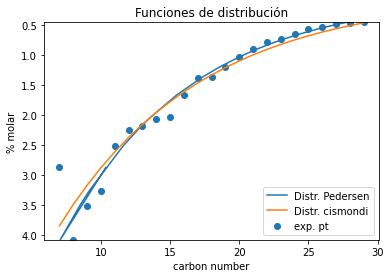

In [207]:
plt.plot(carbon_number(z_exp, A, B),z_exp, label = 'Distr. Pedersen')
plt.plot(c_n,cismondi_z(c_n,Ac,Bc),label= 'Distr. cismondi')
plt.scatter(c_n,z_exp, label = 'exp. pt')
plt.ylabel('% molar')
plt.xlabel('carbon number')
plt.ylim(max(z_exp),min(z_exp))
plt.title('Funciones de distribución')
plt.legend(loc='lower right')

## Minimización de funciones

In [208]:
#Ingreso nc inicial, final y la func de cálculo de masa molar que va a utilizar
def res_fraction(c_max, c_min, m_func):   
    n = 1000                                                                      #número de veces que voy a iterar
    c_range = np.linspace(c_min, c_max, n, dtype=int)
    z_values = molar_fraction(c_range, A, B)                                      #calcula la fracción molar con la ec. de Pedersen
    m_values = m_func(c_range)                                                    #saca los valores de masa molar de todo el rango de nc con la ec. que elijo
    
    m_plus = np.array([])                                                         
    
    for i in range(0, n):
        m_plus = np.append(                                                       #completa Masa molar de la fracción + (ecuación de Pedersen) para dif. Cmax
            m_plus,
            (z_values[:i]*m_values[:i]).sum() / z_values[:i].sum()
        )    

    return z_values, c_range, m_values, m_plus

In [209]:
z, c, m, mp = res_fraction(80, c_plus_n, pedersen_M)        # Uso Cmax de Ped, el cplus(30+) e ingreso la distr. de Pedersen

dfmin = pd.DataFrame()
dfmin['molarperc_values']=z
dfmin['c_range']=c
dfmin['molarmass_values']=m
dfmin['molarmass_plus']=mp

dfmin.set_index('c_range')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


,molarperc_values,molarmass_values,molarmass_plus
c_range,,,
30,0.353625,416,NaN
30,0.353625,416,416.000000
30,0.353625,416,416.000000
30,0.353625,416,416.000000
30,0.353625,416,416.000000
...,...,...,...
79,0.001906,1102,536.974111
79,0.001906,1102,536.989583
79,0.001906,1102,537.005055


In [210]:
def fit_mp(cmax, obj_mp, c_plus_n, m_func):
    """Error cuadrado entre peso molecular M+ estimado y real.
    """
    _, _, _, mp = res_fraction(cmax, c_plus_n, m_func)
    return (mp[-1] - obj_mp)**2

In [211]:
cis = lambda x: cismondi_M(x, C)                 #x es i que va a ser el nc 

minimize_scalar(
        fit_mp,
        args=(m_plus_max, c_plus_n, cis),
)

# Encuentro el Cmax que minimice el error cuadrado entre M+ estimado con Cismondi y el real

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


     fun: 0.00028737650868136655
    nfev: 30
     nit: 23
 success: True
       x: 36.992338412022136

In [212]:
minimize_scalar(
        fit_mp,
        args=(m_plus_max, c_plus_n, pedersen_M)
    )

#Mismo proceso, minimizando el error cuadrado entre M+ estimado con Pedersen y el real 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


     fun: 6.3195203935139135e-06
    nfev: 32
     nit: 25
 success: True
       x: 36.42930573126994

## DISTRIBUCIÓN




In [213]:
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/charact/KatzFiroo"> KatzFiroo.csv
KF = pd.read_csv('KatzFiroo.csv')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   500  100   500    0     0   5617      0 --:--:-- --:--:-- --:--:--  5617


In [214]:
Cn_max = 37                                     
cn_mini = c_n[-1]

"""MplusPed = dfmin['molarmass_plus'][36]"""    #Valor muy diferente al de tabla exp.
"""zplus = dfmin['molarperc_values'][36]"""     #Valor muy diferente al de tabla exp

c_dist = np.array([range(c_n[-1]+1,Cn_max)])

mm_plus = float(df_mbc['molar_mass'][-1])
mp_plus = float(df_mbc['molar_percentage'][-1])

#Cismondi 
Mmi_c = cismondi_M(c_dist,C).round(2)                 #tendencia aum. OK
zi_c = cismondi_z(c_dist,Ac,Bc).round(2)
rho_cis = cismondi_rho(c_dist,AD).round(2)

#Pedersen
Mmi_ped = pedersen_M(c_dist).round(2)                    #aumenta OK
zi_ped = molar_fraction(c_dist,A,B).round(2)             #disminuye OK
rho_ped = pedersen_rho(c_dist,L,M).round(2)

In [215]:
df_ped = df_mbc.drop([df_mbc.index[-1]],axis=0).reset_index().drop('ID',axis=1)
df_cis = df_mbc.drop([df_mbc.index[-1]],axis=0).reset_index().drop('ID',axis=1)

for i in range(0,Cn_max-cn_mini-1):
  df_ped = df_ped.append({'component':'C'+str(cn_mini+1+i),'molar_mass':Mmi_ped[0:,i], 'molar_percentage':zi_ped[0:,i],'density':rho_ped[0:,i]},ignore_index=True)
  df_cis = df_cis.append({'component':'C'+str(cn_mini+1+i),'molar_mass':Mmi_c[0:,i],'molar_percentage':zi_c[0:,i],'density':rho_cis[0:,i]}, ignore_index=True)

# Molar mass Pedersen check con Katz y Firoozabadi(lb/lb-mol)
df_ped['molar_percentage'].sum(), df_cis['molar_percentage'].sum() 
df_ped.set_index('component'), df_cis.set_index('component') 

(          molar_mass density molar_percentage
 component                                    
 N2                 —       —             0.49
 CO2                —       —             0.31
 C1                 —       —            44.01
 C2                 —       —             3.84
 C3                 —       —             1.12
 C4                 —       —             1.33
 C5                 —       —             1.04
 C6                 —       —             1.04
 C7                96   0.738             2.87
 C8               107   0.765             4.08
 C9               121   0.781             3.51
 C10              134   0.792             3.26
 C11              147   0.796             2.51
 C12              161   0.810             2.24
 C13              175   0.825             2.18
 C14              190   0.836             2.07
 C15              206   0.842             2.03
 C16              222   0.849             1.67
 C17              237   0.845             1.38
 C18         

In [216]:
def elx(c,z,cmax,ve):
  x = list(range(c[-1],cmax))
  m = (z[-1]-z[-ve])/(c[-1]-c[-ve])
  b = z[-ve]-m*c[-ve]
  y = np.array([])
  for i in x: 
    y = np.append(y,m*i+b) 
  return y,x

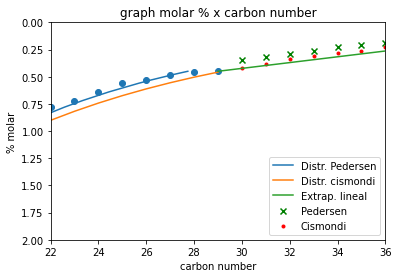

In [217]:
plt.plot(carbon_number(z_exp, A, B),z_exp, label = 'Distr. Pedersen')
plt.plot(c_n,cismondi_z(c_n,Ac,Bc),label= 'Distr. cismondi')
plt.scatter(c_n,z_exp)
plt.ylabel('% molar')
plt.xlabel('carbon number')
plt.ylim(2,0)
plt.xlim(22,36)
plt.title('graph molar % x carbon number')

#Extrapolación lineal
z_extrap,c_extrap = elx(c_n,z_exp,37,4)
plt.plot(c_extrap,z_extrap, label= 'Extrap. lineal')

#Pedersen
plt.scatter(c_dist,zi_ped,label = 'Pedersen', marker = 'x', color='green')
#Cismondi
plt.scatter(c_dist,zi_c, label = 'Cismondi', marker = '.', color='red')

plt.legend(loc='lower right')

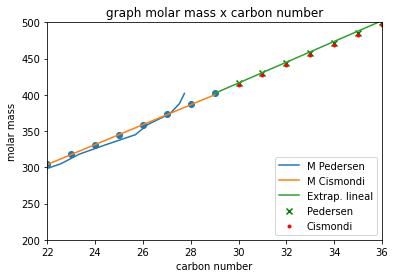

In [218]:
plt.plot(carbon_number(z_exp, A, B),exp_molar_mass, label = 'M Pedersen')
plt.plot(c_n,cismondi_M(c_n,C),label= 'M Cismondi')
plt.scatter(c_n,exp_molar_mass)
plt.ylabel('molar mass')
plt.xlabel('carbon number')
plt.ylim(200,500)
plt.xlim(22,36)
plt.title('graph molar mass x carbon number')

#Extrapolación lineal
m_extrap,c_extrap = elx(c_n,exp_molar_mass,37,4)
plt.plot(c_extrap,m_extrap, label= 'Extrap. lineal')

#Pedersen
plt.scatter(c_dist,Mmi_ped,label = 'Pedersen', marker = 'x', color='green')
#Cismondi
plt.scatter(c_dist,Mmi_c, label = 'Cismondi', marker = '.', color='red')

plt.legend(loc='lower right')

# 2. Pseudo-compuestos: Correlaciones de propiedades
## ***Pedersen*** :

# ✒ ${T_c}$ = ${c_1}$ ${\rho_1}$  + ${c_2}$ ln M + ${c_3}$ M + ${\frac{c4}{M}}$

# ✒ ln ${P_c}$ = ${d_1}$ + ${d_2}$ $\rho^{{d_5}}$ + ${\frac{d_3}{M}}$ + ${\frac{d_4}{M^{2}}}$

# ✒ ${m}$ = ${e_1}$ + ${e_2}$ M  + ${e_3}$ ${\rho}$ + ${e_4}$ ${M^{2}}$


m se relaciona con ${\omega}$, según corresponda:

### SRK:
## m = 0.480 + 1.574 ${\omega}$ - 0.176 ${{\omega}^{2}}$

### PR:
## m = 0.37464 + 1.54226 ${\omega}$ - 0.26992 ${{\omega}^{2}}$





In [219]:
def pedersen_Tc(M,rho,c1,c2,c3,c4):
    return c1*rho + c2*(np.log(M)) + c3*M + (c4/M)

def pedersen_Pc(M,rho,d1,d2,d3,d4,d5):
    lnPc = d1 + d2*(rho*np.exp(d5) + d3/M + d4/(M*np.exp(2)))
    return np.exp(lnPc)

In [220]:
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/charact/Coeff-C"> CoefC.csv
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/charact/Coeff-d"> Coefd.csv
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/charact/Coeff-e"> Coefe.csv

Coef_c = pd.read_csv('CoefC.csv')
Coef_d = pd.read_csv('Coefd.csv')
Coef_e = pd.read_csv('Coefe.csv')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    87  100    87    0     0    604      0 --:--:-- --:--:-- --:--:--   604
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   112  100   112    0     0   1647      0 --:--:-- --:--:-- --:--:--  1647
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   113  100   113    0     0   1448      0 --:--:-- --:--:-- --:--:--  1448


In [221]:
df_ped['Tc_SRK'] = df_ped['density']
df_ped['Pc_SRK'] = df_ped['density']
df_ped['Tc_PR'] = df_ped['density']
df_ped['Pc_PR'] = df_ped['density']

df_cis['Tc_SRK'] = df_cis['density']
df_cis['Pc_SRK'] = df_cis['density']
df_cis['Tc_PR'] = df_cis['density']
df_cis['Pc_PR'] = df_cis['density']

In [222]:
lst = [i for i in range(8,Cn_max+1)]
for i in lst:
  M_cismondi = float(df_cis['molar_mass'][i])
  rho_cismondi = float(df_cis['density'][i])
  M_pedersen = float(df_ped['molar_mass'][i])
  rho_pedersen = float(df_ped['density'][i])

  Tc_PEDER_SRK = pedersen_Tc(M_pedersen,rho_pedersen,Coef_c['SRK'][0],Coef_c['SRK'][1],Coef_c['SRK'][2],Coef_c['SRK'][3])
  Pc_PEDER_SRK = pedersen_Pc(M_pedersen,rho_pedersen,Coef_d['SRK'][0], Coef_d['SRK'][1],Coef_d['SRK'][2], Coef_d['SRK'][3],Coef_d['SRK'][4])
  Tc_PEDER_PR = pedersen_Tc(M_pedersen,rho_pedersen,Coef_c['PR'][0],Coef_c['PR'][1],Coef_c['PR'][2],Coef_c['PR'][3])
  Pc_PEDER_PR = pedersen_Pc(M_pedersen,rho_pedersen,Coef_d['PR'][0], Coef_d['PR'][1], Coef_d['PR'][2], Coef_d['PR'][3],Coef_d['PR'][4])

  Tc_CISM_SRK = pedersen_Tc(M_cismondi,rho_cismondi,Coef_c['SRK'][0],Coef_c['SRK'][1],Coef_c['SRK'][2],Coef_c['SRK'][3])
  Pc_CISM_SRK = pedersen_Pc(M_cismondi,rho_cismondi,Coef_d['SRK'][0], Coef_d['SRK'][1], Coef_d['SRK'][2], Coef_d['SRK'][3],Coef_d['SRK'][4])
  Tc_CISM_PR = pedersen_Tc(M_cismondi,rho_cismondi,Coef_c['PR'][0],Coef_c['PR'][1],Coef_c['PR'][2],Coef_c['PR'][3])
  Pc_CISM_PR = pedersen_Pc(M_cismondi,rho_cismondi,Coef_d['PR'][0], Coef_d['PR'][1], Coef_d['PR'][2], Coef_d['PR'][3],Coef_d['PR'][4])

  df_ped['Tc_SRK'][i] = Tc_PEDER_SRK
  df_ped['Pc_SRK'][i] = Pc_PEDER_SRK
  df_ped['Tc_PR'][i] = Tc_PEDER_PR
  df_ped['Pc_PR'][i] = Pc_PEDER_PR

  df_cis['Tc_SRK'][i] = Tc_CISM_SRK
  df_cis['Pc_SRK'][i] = Pc_CISM_SRK
  df_cis['Tc_PR'][i] = Tc_CISM_PR
  df_cis['Pc_PR'][i] = Pc_CISM_PR

In [223]:
df_ped

,component,molar_mass,density,molar_percentage,Tc_SRK,Pc_SRK,Tc_PR,Pc_PR
0,N2,—,—,0.49,—,—,—,—
1,CO2,—,—,0.31,—,—,—,—
2,C1,—,—,44.01,—,—,—,—
3,C2,—,—,3.84,—,—,—,—
4,C3,—,—,1.12,—,—,—,—
5,C4,—,—,1.33,—,—,—,—
6,C5,—,—,1.04,—,—,—,—
7,C6,—,—,1.04,—,—,—,—
8,C7,96,0.738,2.87,535.237601,0.023629,536.468973,0.001374
9,C8,107,0.765,4.08,555.758522,0.068947,558.023149,0.00364


In [224]:
df_cis

,component,molar_mass,density,molar_percentage,Tc_SRK,Pc_SRK,Tc_PR,Pc_PR
0,N2,—,—,0.49,—,—,—,—
1,CO2,—,—,0.31,—,—,—,—
2,C1,—,—,44.01,—,—,—,—
3,C2,—,—,3.84,—,—,—,—
4,C3,—,—,1.12,—,—,—,—
5,C4,—,—,1.33,—,—,—,—
6,C5,—,—,1.04,—,—,—,—
7,C6,—,—,1.04,—,—,—,—
8,C7,96,0.738,2.87,535.237601,0.023629,536.468973,0.001374
9,C8,107,0.765,4.08,555.758522,0.068947,558.023149,0.00364


#Lumping
##Crit: "Average" Boiling Point (°C)

In [264]:
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/charact/BoilingPoint"> BoilingPoint.csv
BP = pd.read_csv('BoilingPoint.csv')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   268  100   268    0     0   2881      0 --:--:-- --:--:-- --:--:--  2851


In [262]:
df_cis['Boiling point'] = df_cis['density']
df_ped['Boiling point'] = df_ped['density']

for i in BP['CN']:
  posC1 = df_cis.index[df_cis['component']==i][0]
  posi= BP.index[BP['CN']==i][0]
  df_cis['Boiling point'][posC1]=BP[' average_bp'][posi]
  df_ped['Boiling point'][posC1]=BP[' average_bp'][posi]

TypeError: ignored